## Alocação de unidades de atendimento móvel do CBMERJ de Campos dos Goytacazes - RJ

In [59]:
# Library
import pathlib
import os
import sys

import numpy as np
import pandas as pd
from pulp import *
from utils.process import stander_text
# my packges
sys.path.insert(0, str(pathlib.Path().absolute().parent))

import process.allocation as allocation
from process.geocode import *

import plotly.express as px
import plotly.io as pio
import seaborn as sns


In [3]:
pio.templates.default = "seaborn"

**Importar dados**

In [4]:
df_matrix= pd.read_excel('../data/matriz_tempo.xlsx', index_col=0)

In [5]:
df_matrix

,5 GBM,DBM 1/5 GUARUS,HOSP. FERREIRA M,HOSP. G. GUARUS,HOSP. SÃO JOSÉ,HOSP. TRAVESSÃO,PS GUARUS,SANDU,UBS Sartunino Braga,UBS TOCOS,UPA,UPH F. SÃO THOMÉ,UPH MORRO DO COCO,UPH ST EDUARDO
Clientes,,,,,,,,,,,,,,
Alphaville,1132,1997,1449,1345,527,2579,1450,972,1610,1348,1706,3454,4157,5609
Baixa Grande,3004,3869,3321,3217,1923,4451,3322,2844,655,2062,3578,1189,6029,7481
Boa Vista,3536,4401,3852,3749,2454,4982,3854,3375,1186,2432,4109,673,6561,8012
Caboio,2808,3673,3124,3021,1726,4254,3126,2647,1025,1404,3381,1925,5833,7284
Caju,508,768,150,591,1712,1331,368,811,2794,2422,412,4638,2909,4361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Industrial,982,223,909,800,2304,1050,826,1323,3386,3124,521,5231,2629,4080
Vila MANHÃES,1077,1942,1394,1290,974,2524,1455,999,1524,1571,1650,3369,4102,5554
Vila Nova de Campos,2751,2197,2625,2570,4073,1425,2596,3093,5155,4893,2238,7000,1052,2580


# Modelo matemático

In [6]:
# DEFININDO VARIÁVEIS
location = df_matrix.columns.values
clients = df_matrix.index.values 
w = [1 for w in clients]
m = df_matrix.shape[0] # Nº de clientes
n = df_matrix.shape[1] # Nº de potenciais facilidades
p = 9 # Nº de facilidades   


### Cenários
**Cenário base**

In [75]:
# Cenario base
bases_atuais = ['5 GBM', 'DBM 1/5 GUARUS', 'HOSP. G. GUARUS']
scenario_base = df_matrix[bases_atuais].apply(min, axis=1).copy()
df_matrix[bases_atuais].apply(min, axis=1).describe()

count     165.000000
mean     1108.818182
std       957.543136
min       122.000000
25%       447.000000
50%       722.000000
75%      1447.000000
max      4075.000000
dtype: float64

**Cenário ponderado**

In [8]:
# Carregar arquivo de pesos
df_weight = pd.read_csv('../data/pesos_manchester_adaptado.csv', delimiter=';')
# Agregar para eliminar valores duplicados
df_weight = df_weight.groupby('Clientes').sum().reset_index()

In [9]:
df_bairros_ponderado = df_matrix.copy()
df_bairros_ponderado = df_bairros_ponderado.reset_index()[['Clientes']]
df_bairros_ponderado = df_bairros_ponderado.merge(df_weight, left_on='Clientes', right_on='Clientes', how='left')
df_bairros_ponderado.head()

,Clientes,Bairros,Inverno,Outono,Primavera,Verão,2017,2018,2019,2020,Total Geral
0,Alphaville,Alphaville,8.0,26.0,12.0,3.0,28.0,9.0,12.0,0.0,49
1,Baixa Grande,Baixa Grande,2.0,0.0,4.0,0.0,0.0,0.0,6.0,0.0,6
2,Boa Vista,Boa Vista,20.0,70.0,38.0,76.0,18.0,62.0,124.0,0.0,204
3,Caboio,Caboio,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4
4,Caju,Caju,48.0,78.0,42.0,50.0,43.0,87.0,88.0,0.0,218


In [10]:
scenarios = {
    'Não ponderado':[1 for x in range(m)],
    'Ponderado':df_bairros_ponderado['Total Geral'].to_list(),
    'Inverno': df_bairros_ponderado['Inverno'].to_list(),
    'Outono':df_bairros_ponderado['Outono'].to_list(),
    'Primavera':df_bairros_ponderado['Primavera'].to_list(),
    'Verão':df_bairros_ponderado['Verão'].to_list(),
}

**Rodar modelo**

In [11]:
# Lista contendo os resultado dos cenários
results = []
for scenario, weigts in scenarios.items():
    p_median = allocation.Allocation(m, n, p, df_matrix, weigts)
    p_median.solver()
    res = p_median.get_result()
    results.append({scenario:res})

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/fabio/PycharmProjects/P-Median/env/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8ff6c996596f4cfcaea2a7d5e9f78b3d-pulp.mps -sec 600 -ratio 0.0 -threads 1 -timeMode elapsed -branch -printingOptions all -solution /tmp/8ff6c996596f4cfcaea2a7d5e9f78b3d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2481 COLUMNS
At line 16382 RHS
At line 18859 BOUNDS
At line 21184 ENDATA
Problem MODEL has 2476 rows, 2324 columns and 6944 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
ratioGap was changed from 0 to 0
threads was changed from 0 to 1
Option for timeMode changed from cpu to elapsed
Continuous objective value is 111204 - 0.01 seconds
Cgl0004I processed model has 2476 rows, 2324 columns (2324 integer (2324 of which binary)) and 6944 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state 

In [12]:
class GetResultPmedian:
    def __init__(self, results):
        self.results = results    
    
    def struct_results(self: list):
        self.scenario_results = {}
        self.open_facilities = {}
        self.times = {}
        stats = []
        for res in self.results:
            key, value = zip(*res.items())
            self.open_facilities.update({key[0]:value[0][0]})
            self.scenario_results.update({
                key[0]:['\n'.join(value[0][0])]
            }) 
            stats.append(
                pd.Series(value[0][1]).describe().reset_index().set_index('index').T
            )
            self.times.update({key:value[0][1]})
        df_stats = pd.concat(stats, ignore_index=True)
        df = pd.DataFrame(self.scenario_results).melt(var_name='Cenários', value_name='Bases')
        return df.join(df_stats)
    
    def get_facilities_open(self):
        structured_data_from_open_facilities = {key:[] for key in ['bases',*self.open_facilities.keys()]}
        facilities = self._get_all_facilities()
        structured_data_from_open_facilities['bases'].extend(facilities)
        
        for base in facilities:
            for scenario, open_bases in self.open_facilities.items():
                if base in open_bases:
                    structured_data_from_open_facilities[scenario].append(1)  
                else:
                    structured_data_from_open_facilities[scenario].append(0) 
                
        return pd.DataFrame(structured_data_from_open_facilities)
    
    def get_times(self):
        return pd.DataFrame(self.times)
    
    def _get_all_facilities(self):
        _,_,matrix = zip(*self.results[0].values())
        return matrix[0].columns

In [70]:
res_pmedian = GetResultPmedian(results)

struct_results = res_pmedian.struct_results()
struct_results.to_excel('cenarios.xlsx')    
struct_results

,Cenários,Bases,count,mean,std,min,25%,50%,75%,max
0,Não ponderado,DBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP. SÃO JO...,165.0,673.963636,648.410626,0.0,315.0,450.0,712.0,3687.0
1,Ponderado,5 GBM\nDBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP....,165.0,781.290909,821.582063,43.0,307.0,453.0,880.0,4120.0
2,Inverno,5 GBM\nDBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP....,165.0,898.563636,945.722664,43.0,311.0,516.0,1017.0,4606.0
3,Outono,5 GBM\nDBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP....,165.0,914.242424,993.509775,43.0,315.0,517.0,1007.0,4606.0
4,Primavera,5 GBM\nDBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP....,165.0,902.896970,971.846838,43.0,310.0,516.0,1028.0,4606.0
5,Verão,5 GBM\nDBM 1/5 GUARUS\nHOSP. FERREIRA M\nHOSP....,165.0,868.527273,875.399843,0.0,319.0,511.0,1026.0,4120.0


In [14]:
facilities_open = res_pmedian.get_facilities_open()
facilities_open.to_excel('bases_abertas.xlsx')  
facilities_open   

,bases,Não ponderado,Ponderado,Inverno,Outono,Primavera,Verão
0,5 GBM,0,1,1,1,1,1
1,DBM 1/5 GUARUS,1,1,1,1,1,1
2,HOSP. FERREIRA M,1,1,1,1,1,1
3,HOSP. G. GUARUS,0,0,0,0,0,0
4,HOSP. SÃO JOSÉ,1,1,1,1,1,1
5,HOSP. TRAVESSÃO,1,1,1,1,1,1
6,PS GUARUS,0,1,1,1,1,0
7,SANDU,1,1,1,1,1,1
8,UBS Sartunino Braga,1,1,1,1,1,1
9,UBS TOCOS,1,0,0,0,0,0


## Visualização

In [97]:
times = res_pmedian.get_times()
times.insert(0,'Atual',scenario_base.values)

fig = px.box(
    times.melt(var_name='Cenario'),
    x='value',
    facet_row='Cenario',
    title='Tempo de deslocamento - segundos',
    labels={'value':'Tempo de deslocamento (s)'},
    height=800,
    width=800,
)
fig.show()

# Alterar os nomes dos subgráficos
# fig.for_each_annotation(lambda name: name.update(text=name.text.replace("variable=", "")))
fig.write_image("boxplot.svg")

Text(0, 0.5, 'Cenário')

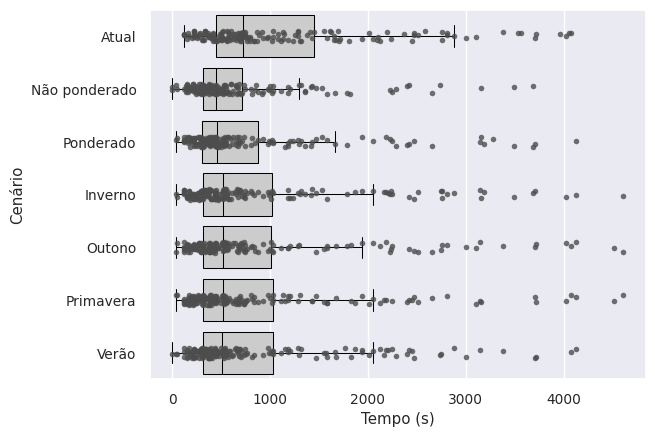

In [130]:
sns.set_theme()
sns.set_context("notebook", font_scale=.9)
ax = sns.boxplot(
    data=times.melt(var_name='Cenario'),
    x='value', 
    y="Cenario",
    # native_scale=True
    # notch=True,
    flierprops={'markeredgecolor': '#000', 'markerfacecolor': '.8', 'alpha':.8},
    color=".8",
    linecolor="#000", 
    linewidth=.75,
    # width=900
    showfliers = False
)
sns.stripplot(
    times.melt(var_name='Cenario'),  x='value',  y="Cenario", size=4, color=".3", alpha=.8)
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Cenário')



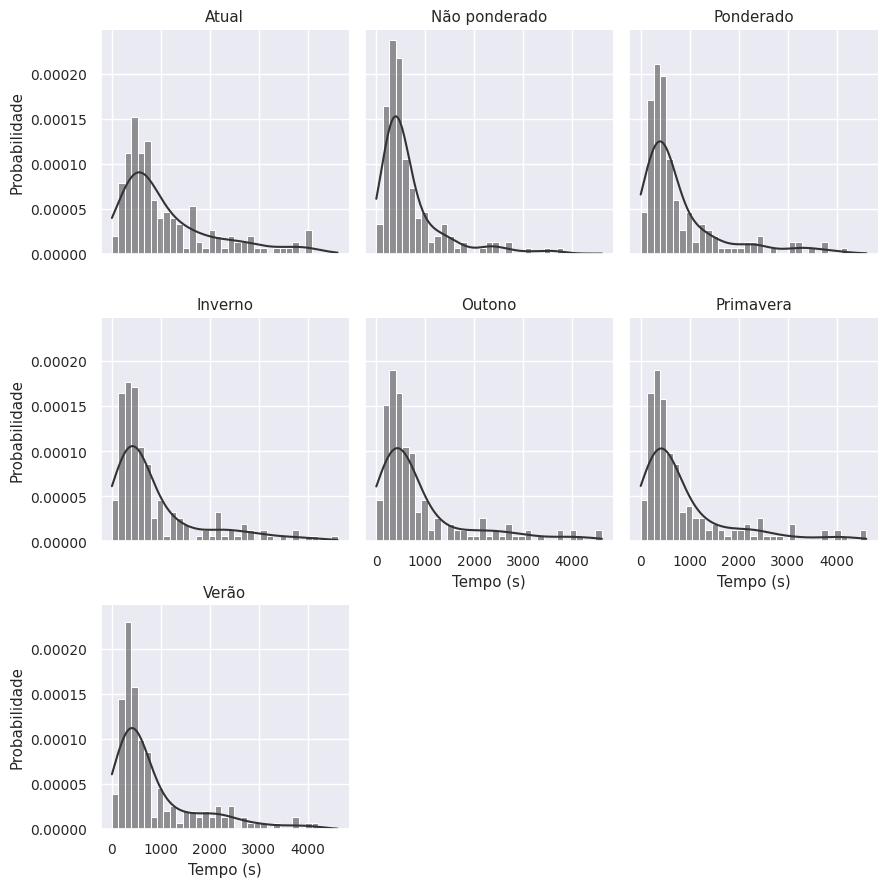

In [180]:
g = sns.displot(
    data=times.melt(var_name='Cenario'),
    x='value', col='Cenario',
    # kind='kde',
    col_wrap=3,
    aspect=1, 
    height=3,
    kde=True,
    stat="density",
    facet_kws=dict(margin_titles=True),
     color=".2",
    linewidth=.75,
)
g.set_axis_labels("Tempo (s)", "Probabilidade")
g.set_titles(template="")
g.set_titles("{col_name}")
# g.fig.subplots_adjust(top=0.9)

# for ax in g.axes.flat:
#     ax.set_xlabel("Valores")
#     ax.set_ylabel("Densidade")


In [16]:
print(results[0]['Não ponderado'][2].apply(max, axis=1).mean())
print(np.mean(results[0]['Não ponderado'][1]))
print(results[0]['Não ponderado'][2].apply(max))


673.9636363636364
673.9636363636364
5 GBM                     0
DBM 1/5 GUARUS          550
HOSP. FERREIRA M       3687
HOSP. G. GUARUS           0
HOSP. SÃO JOSÉ         1107
HOSP. TRAVESSÃO        1815
PS GUARUS                 0
SANDU                  1533
UBS Sartunino Braga    1668
UBS TOCOS               426
UPA                    1418
UPH F. SÃO THOMÉ          0
UPH MORRO DO COCO         0
UPH ST EDUARDO         2736
dtype: int64


In [17]:
print(results[1]['Ponderado'][2].apply(max, axis=1).mean())
np.mean(results[1]['Ponderado'][1])
print(results[1]['Ponderado'][2].apply(max, axis=0))
results[1]['Ponderado'][2]

781.290909090909
5 GBM                  4120
DBM 1/5 GUARUS          550
HOSP. FERREIRA M       3687
HOSP. G. GUARUS           0
HOSP. SÃO JOSÉ         1231
HOSP. TRAVESSÃO        3280
PS GUARUS               289
SANDU                  1533
UBS Sartunino Braga    1668
UBS TOCOS                 0
UPA                    1418
UPH F. SÃO THOMÉ          0
UPH MORRO DO COCO         0
UPH ST EDUARDO            0
dtype: int64


,5 GBM,DBM 1/5 GUARUS,HOSP. FERREIRA M,HOSP. G. GUARUS,HOSP. SÃO JOSÉ,HOSP. TRAVESSÃO,PS GUARUS,SANDU,UBS Sartunino Braga,UBS TOCOS,UPA,UPH F. SÃO THOMÉ,UPH MORRO DO COCO,UPH ST EDUARDO
Clientes,,,,,,,,,,,,,,
Alphaville,0,0,0,0,527,0,0,0,0,0,0,0,0,0
Baixa Grande,0,0,0,0,0,0,0,0,655,0,0,0,0,0
Boa Vista,0,0,0,0,0,0,0,0,1186,0,0,0,0,0
Caboio,0,0,0,0,0,0,0,0,1025,0,0,0,0,0
Caju,0,0,150,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Industrial,0,223,0,0,0,0,0,0,0,0,0,0,0,0
Vila MANHÃES,0,0,0,0,974,0,0,0,0,0,0,0,0,0
Vila Nova de Campos,0,0,0,0,0,1425,0,0,0,0,0,0,0,0


In [18]:
print(results[4]['Primavera'][2].apply(max, axis=1).mean())
np.mean(results[4]['Primavera'][1])
print(results[4]['Primavera'][2].apply(max, axis=0))
results[4]['Primavera'][2]

902.8969696969697
5 GBM                  4606
DBM 1/5 GUARUS          550
HOSP. FERREIRA M       3157
HOSP. G. GUARUS           0
HOSP. SÃO JOSÉ         1153
HOSP. TRAVESSÃO        1425
PS GUARUS               289
SANDU                   690
UBS Sartunino Braga    1186
UBS TOCOS                 0
UPA                     451
UPH F. SÃO THOMÉ          0
UPH MORRO DO COCO         0
UPH ST EDUARDO            0
dtype: int64


,5 GBM,DBM 1/5 GUARUS,HOSP. FERREIRA M,HOSP. G. GUARUS,HOSP. SÃO JOSÉ,HOSP. TRAVESSÃO,PS GUARUS,SANDU,UBS Sartunino Braga,UBS TOCOS,UPA,UPH F. SÃO THOMÉ,UPH MORRO DO COCO,UPH ST EDUARDO
Clientes,,,,,,,,,,,,,,
Alphaville,0,0,0,0,527,0,0,0,0,0,0,0,0,0
Baixa Grande,0,0,0,0,0,0,0,0,655,0,0,0,0,0
Boa Vista,0,0,0,0,0,0,0,0,1186,0,0,0,0,0
Caboio,2808,0,0,0,0,0,0,0,0,0,0,0,0,0
Caju,0,0,150,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Industrial,0,223,0,0,0,0,0,0,0,0,0,0,0,0
Vila MANHÃES,0,0,0,0,974,0,0,0,0,0,0,0,0,0
Vila Nova de Campos,0,0,0,0,0,1425,0,0,0,0,0,0,0,0


In [19]:
print(results[5]['Verão'][2].apply(max, axis=1).mean())
np.mean(results[5]['Verão'][1])
print(results[5]['Verão'][2].apply(max, axis=0))


868.5272727272727
5 GBM                  4120
DBM 1/5 GUARUS          550
HOSP. FERREIRA M       2423
HOSP. G. GUARUS           0
HOSP. SÃO JOSÉ         1153
HOSP. TRAVESSÃO         477
PS GUARUS                 0
SANDU                  1292
UBS Sartunino Braga    1668
UBS TOCOS                 0
UPA                     482
UPH F. SÃO THOMÉ          0
UPH MORRO DO COCO         0
UPH ST EDUARDO         2736
dtype: int64
